# Variational Autoencoders - Aula Prática

## Configurações

Importando módulos necessários

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as T

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from math import ceil, sqrt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torchsummary import summary

## Introdução

Variational Autoencoders (VAEs) são uma classe de modelos generativos que são treinados para representar dados de entrada em um espaço latente de baixa dimensão. Eles são baseados em redes neurais e são treinados usando métodos de inferência variacional. VAEs são uma extensão de autoencoders tradicionais, que são usados para aprender representações compactas de dados de entrada. A principal diferença entre VAEs e autoencoders tradicionais é que VAEs são treinados para aprender a distribuição de probabilidade dos dados de entrada, enquanto autoencoders tradicionais são treinados para aprender uma função de mapeamento determinística dos dados de entrada para um espaço latente.

Nessa aula prática, vamos implementar um Variational Autoencoder para reconstruir imagens do dataset MNIST.

## Dataset

Vamos começar carregando o dataset MNIST. O dataset é composto por imagens de dígitos escritos à mão, com dimensões 28x28 pixels.

In [2]:
mnist_path = '/pgeoprj2/ciag2024/dados'

In [78]:
def plot_dataset(dataset, n=16, figsize=(6, 6), label_mapper=lambda x: x):
    cols = ceil(sqrt(n))
    rows = ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i, ax in enumerate(axes.flat):
        if i == 0:
            print(f"image shape: {dataset[i][0].shape}")
        image, _, label = dataset[i]
        ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
        ax.set_title(f"{label_mapper(label)}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
"""
Como queremos que o autoencoder aprenda a reconstruir a imagem de entrada,
reformulamos o dataset MNIST para que ele retorne a mesma imagem como entrada e saída.
"""
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [5]:
mnist_train_ds = AutoencoderMNIST(
    mnist_path,
    train=True,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    download=True,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    mnist_path,
    train=False,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


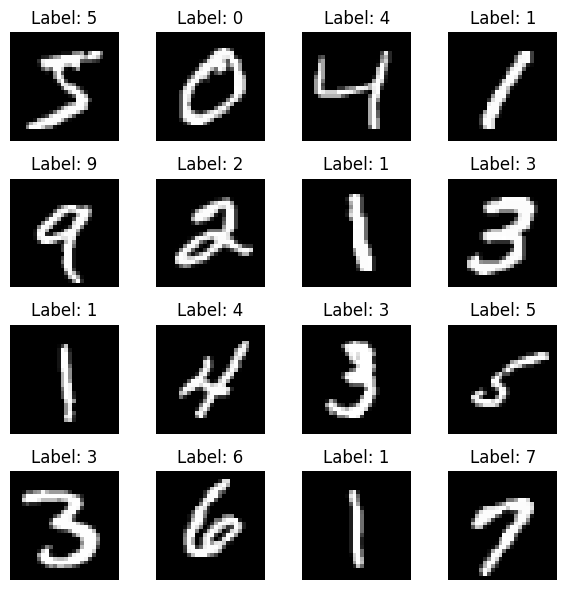

In [6]:
plot_dataset(mnist_train_ds)

## Modelo

Como já mencionado, um VAE é composto por duas partes principais: um encoder e um decoder. O encoder é uma rede neural que mapeia os dados de entrada para um espaço latente de baixa dimensão, enquanto o decoder é uma rede neural que mapeia os pontos no espaço latente de volta para o espaço de entrada.

O principal da arquitetura já vimos na aula sobre Autoencoders tradicionais, mas a diferença é que o encoder de um VAE mapeia os dados de entrada para uma distribuição de probabilidade no espaço latente, em vez de mapear os dados de entrada para um ponto específico no espaço latente, como podemos ver na imagem abaixo:

O encder vai transformar os dados em $ \mu $ e $ \sigma $, que são os parâmetros da distribuição normal que representa o espaço latente, seguindo a fórmula:

$$ 
z = \mu + \sigma \cdot \epsilon 
$$

com $ \epsilon $ sendo uma amostra de uma distribuição normal padrão.

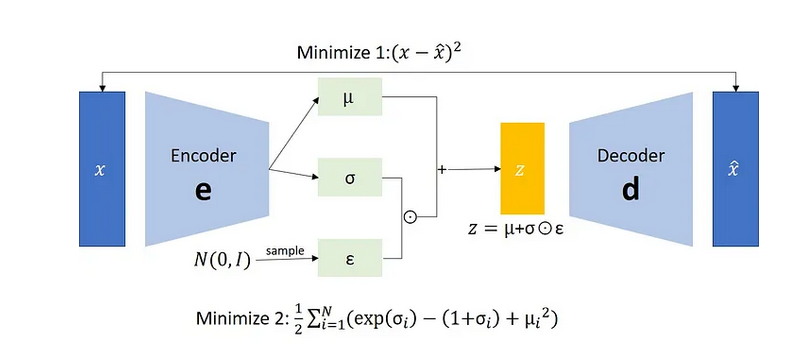

In [7]:
class VariationalConvolutionalEncoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalConvolutionalEncoder, self).__init__()
        self.latent_size = latent_size

        # reduzimos o tamanho da imagem
        # considerando input (n_channels, 28, 28)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 16, 3, padding=1),  # (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (16, 14, 14)
            nn.Conv2d(16, 8, 3, padding=1),  # (8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (8, 7, 7)
            nn.Conv2d(8, 2, 3, padding=1),  # (2, 7, 7)
            nn.ReLU(),
        )

        # extraimos as features da imagem reduzida
        self.flatten = nn.Flatten()  # (2 * 7 * 7,) = (98,)

        # finalmente fazemos o encoding da nossa imagem em um vetor n dimensional
        self.z_log_sigma = nn.Linear(98, self.latent_size)
        self.z_mean = nn.Linear(98, self.latent_size)

    @property
    def device(self):
        return next(self.parameters()).device

    # função para amostrar a representação latente a partir da média e desvio padrão
    def sample(self, z_mean, z_log_sigma):
        epsilon = torch.normal(0, 0.1, z_mean.shape, device=self.device)
        return z_mean + torch.exp(z_log_sigma) * epsilon
    
    # função para calcular a divergência KL para a loss
    def kl_divergence(self):
        return -0.5 * torch.sum(1 + self.stdev - self.mean.pow(2) - self.stdev.exp())

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)

        # salvamos os valores de média e desvio padrão para serem usados na loss
        self.stdev = self.z_log_sigma(x)
        self.mean = self.z_mean(x)

        x = self.sample(self.mean, self.stdev)

        return x

In [8]:
# O decoder do VAE é o mesmo que o do AE
class ConvolutionalDecoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalDecoder, self).__init__()
        self.latent_size = latent_size

        # decodificamos a representação latente para uma imagem 7x7
        self.decoder = nn.Linear(self.latent_size, 98)
        self.unflatten = nn.Unflatten(1, (2, 7, 7)) # (2, 7, 7)

        # voltamos a imagem ao tamanho original
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1), # (8, 7, 7)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (8, 14, 14)
            nn.Conv2d(8, 16, 3, padding=1), # (16, 14, 14)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (16, 28, 28)
            nn.Conv2d(16, n_channels, 3, padding=1), # (n_channels, 28, 28)
            nn.Sigmoid(), # sigmoid na última camada para que o output esteja no intervalo [0, 1]
        )

    def forward(self, x):
        x = self.decoder(x)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        return x

In [9]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalConvolutionalEncoder(latent_size, n_channels)
        self.decoder = ConvolutionalDecoder(latent_size, n_channels)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
vae = VariationalAutoencoder(latent_size=2, n_channels=1)
vae.cuda()
summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7              [-1, 2, 7, 7]             146
              ReLU-8              [-1, 2, 7, 7]               0
           Flatten-9                   [-1, 98]               0
           Linear-10                    [-1, 2]             198
           Linear-11                    [-1, 2]             198
VariationalConvolutionalEncoder-12                    [-1, 2]               0
           Linear-13                   [-1, 98]             294
        Unflatten-14     

## Treinando o modelo

Vamos treinar o modelo para reconstruir imagens do dataset MNIST. O modelo será treinado por 20 épocas, com batch size 128 e otimizador Adam.

In [11]:
def loss_to_string(loss, prefix):
    return ' '.join([f'{prefix}_{l}: {loss[l]:.4f}' for l in loss])

def train(model, optimizer, loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = {'loss': 0.0}

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            rec_loss = loss_fn(outputs, targets)
            rec_loss /= inputs.size(0)
            train_losses['rec_loss'] = train_losses.get('rec_loss', 0.0) + rec_loss.item()

            # Adicionamos a divergência KL à loss
            kl_loss = model.encoder.kl_divergence()
            kl_loss /= inputs.size(0)
            train_losses['kl_loss'] = train_losses.get('kl_loss', 0.0) + kl_loss.item()

            loss = rec_loss + kl_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_losses['loss'] += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_losses['loss']/(i+1):.4f}")

        for l in train_losses:
            train_losses[l] /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_losses = {'loss': 0.0}

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    rec_loss = loss_fn(outputs, targets)
                    rec_loss /= inputs.size(0)
                    val_losses['rec_loss'] = val_losses.get('rec_loss', 0.0) + rec_loss.item()

                    kl_loss = model.encoder.kl_divergence()
                    kl_loss /= inputs.size(0)
                    val_losses['kl_loss'] = val_losses.get('kl_loss', 0.0) + kl_loss.item()

                    loss = rec_loss + kl_loss

                    val_losses['loss'] += loss.item()

            for l in val_losses:
                val_losses[l] /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')} | {loss_to_string(val_losses, 'val')}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')}")

In [12]:
vae = VariationalAutoencoder(latent_size=2, n_channels=1)

In [13]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [14]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 60.0252 train_rec_loss: 59.0435 train_kl_loss: 0.9817 | val_loss: 46.9127 val_rec_loss: 46.2010 val_kl_loss: 0.7117


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 44.9951 train_rec_loss: 44.3880 train_kl_loss: 0.6071 | val_loss: 44.1606 val_rec_loss: 43.6306 val_kl_loss: 0.5300


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 43.3959 train_rec_loss: 42.8776 train_kl_loss: 0.5183 | val_loss: 43.1250 val_rec_loss: 42.5959 val_kl_loss: 0.5291


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 42.4547 train_rec_loss: 41.9378 train_kl_loss: 0.5168 | val_loss: 42.2131 val_rec_loss: 41.7031 val_kl_loss: 0.5100


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 41.7282 train_rec_loss: 41.2016 train_kl_loss: 0.5266 | val_loss: 41.5515 val_rec_loss: 41.0185 val_kl_loss: 0.5331


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 40.8763 train_rec_loss: 40.3206 train_kl_loss: 0.5557 | val_loss: 40.5333 val_rec_loss: 39.9529 val_kl_loss: 0.5804


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 40.1340 train_rec_loss: 39.5442 train_kl_loss: 0.5899 | val_loss: 39.8720 val_rec_loss: 39.2727 val_kl_loss: 0.5992


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 39.5462 train_rec_loss: 38.9303 train_kl_loss: 0.6159 | val_loss: 39.3163 val_rec_loss: 38.7292 val_kl_loss: 0.5871


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 39.1001 train_rec_loss: 38.4666 train_kl_loss: 0.6335 | val_loss: 38.8662 val_rec_loss: 38.2199 val_kl_loss: 0.6463


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 38.7263 train_rec_loss: 38.0855 train_kl_loss: 0.6408 | val_loss: 38.6695 val_rec_loss: 38.0376 val_kl_loss: 0.6319


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 38.4579 train_rec_loss: 37.8039 train_kl_loss: 0.6540 | val_loss: 38.3056 val_rec_loss: 37.6674 val_kl_loss: 0.6382


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 38.2021 train_rec_loss: 37.5411 train_kl_loss: 0.6611 | val_loss: 38.0482 val_rec_loss: 37.3722 val_kl_loss: 0.6760


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 37.9964 train_rec_loss: 37.3318 train_kl_loss: 0.6646 | val_loss: 37.9542 val_rec_loss: 37.2574 val_kl_loss: 0.6968


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 37.8199 train_rec_loss: 37.1478 train_kl_loss: 0.6721 | val_loss: 37.6483 val_rec_loss: 36.9900 val_kl_loss: 0.6583


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 37.6665 train_rec_loss: 36.9950 train_kl_loss: 0.6715 | val_loss: 37.5754 val_rec_loss: 36.8686 val_kl_loss: 0.7068


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 37.5366 train_rec_loss: 36.8551 train_kl_loss: 0.6815 | val_loss: 37.4935 val_rec_loss: 36.8019 val_kl_loss: 0.6916


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 37.4148 train_rec_loss: 36.7319 train_kl_loss: 0.6829 | val_loss: 37.3709 val_rec_loss: 36.7038 val_kl_loss: 0.6671


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 37.2977 train_rec_loss: 36.6106 train_kl_loss: 0.6871 | val_loss: 37.2474 val_rec_loss: 36.5274 val_kl_loss: 0.7199


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 37.2112 train_rec_loss: 36.5206 train_kl_loss: 0.6906 | val_loss: 37.1683 val_rec_loss: 36.4627 val_kl_loss: 0.7056


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 37.1223 train_rec_loss: 36.4227 train_kl_loss: 0.6996 | val_loss: 37.1024 val_rec_loss: 36.3845 val_kl_loss: 0.7179


## Analisando os resultados

Nessa etapa, vamos analisar os resultados obtidos pelo autoencoder. Vamos visualizar as imagens de entrada e as imagens reconstruídas pelo autoencoder. Além disso, vamos visualizar a representação dos dados no espaço latente.

In [15]:
def plot_reconstructions(model, dataset, n=8, device='cpu', figsize=(12, 6), plot_label=False):
    fig, axes = plt.subplots(3 if plot_label else 2, n, figsize=figsize)
    images = torch.cat([dataset[i][0].unsqueeze(0) for i in range(n)], dim=0).to(device)
    labels = torch.cat([dataset[i][1].unsqueeze(0) for i in range(n)], dim=0)

    model.to(device)
    model.eval()
    with torch.no_grad():
        reconstructions = model(images)

    for i, (ax, im, rec, lbl) in enumerate(zip(range(n), images, reconstructions, labels)):
        im = im.cpu().squeeze()
        rec = rec.cpu().squeeze()
        lbl = lbl.cpu().squeeze()

        if plot_label:
            axes[0][ax].imshow(lbl, cmap="gray")
            axes[0][ax].axis("off")
            axes[1][ax].imshow(im, cmap="gray")
            axes[1][ax].axis("off")
            axes[2][ax].imshow(rec, cmap="gray")
            axes[2][ax].axis("off")
        else:
            axes[0][ax].imshow(im, cmap="gray")
            axes[0][ax].axis("off")
            axes[1][ax].imshow(rec, cmap="gray")
            axes[1][ax].axis("off")

        if i == n//2:
            if plot_label:
                axes[0][ax].set_title("Original")
                axes[1][ax].set_title("Sample")
                axes[2][ax].set_title("Reconstruction")
            else:
                axes[0][ax].set_title("Sample")
                axes[1][ax].set_title("Reconstruction")

    plt.tight_layout()
    plt.show()

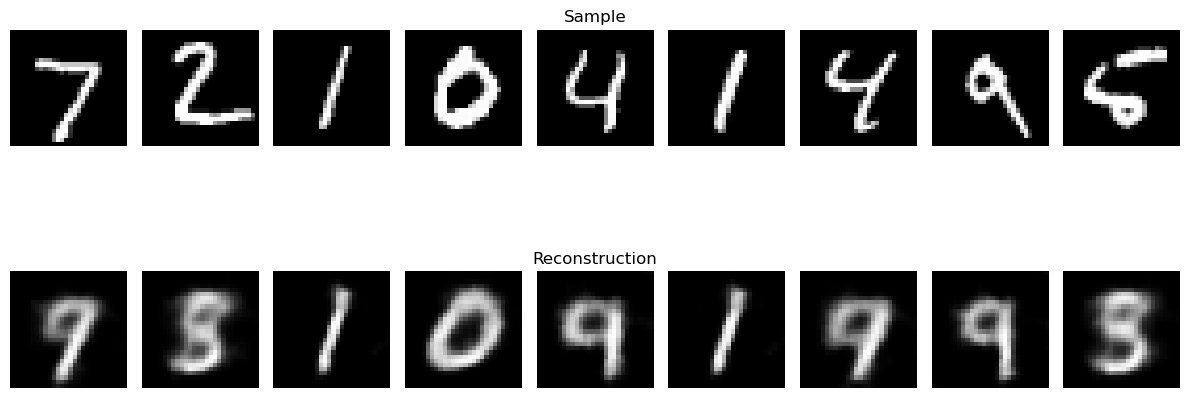

In [16]:
plot_reconstructions(vae, mnist_test_ds, n=9, device=device, plot_label=False)

In [72]:
def plot_latent_space(
    encoder,
    dataset,
    n_classes=10,
    batch_size=128,
    device='cpu',
    reduce_dims=None,
    ax=None,
    title=None,
    label_mapper=lambda x: x,
):
    # Get the latent representations for all test data
    latent_representations = []
    labels_agg = []
    classes = list(range(n_classes))

    dataset.start_return_labels()
    test_dl_with_labels = DataLoader(dataset, batch_size=batch_size)

    encoder.to(device)
    encoder.eval()
    with torch.no_grad():
        for images, _, labels in test_dl_with_labels:
            images = images.to(device)
            latent_vectors = encoder(images)
            latent_representations.append(latent_vectors.cpu().numpy())
            labels_agg.append(labels.numpy())

    # Concatenate all latent representations
    latent_representations = np.concatenate(latent_representations, axis=0)
    labels_agg = np.concatenate(labels_agg, axis=0)

    if reduce_dims is not None:
        if reduce_dims == 'pca':
            pca = PCA(n_components=2, random_state=42)
            latent_representations = pca.fit_transform(latent_representations)
        elif reduce_dims == 'tsne':
            tsne = TSNE(n_components=2, random_state=42)
            latent_representations = tsne.fit_transform(latent_representations)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the latent representations
    cmap = plt.get_cmap('jet', 10)
    for c in classes:
        indices = np.where(labels_agg == c)
        ax.scatter(
            latent_representations[indices, 0],
            latent_representations[indices, 1],
            s=3,
            label=f"{label_mapper(c)}",
            c=[cmap(c)],
            alpha=0.5,
        )
    # add the labels mapping
    ax.legend(markerscale=5)
    if title is None:
        ax.set_title('Latent Representations of Test Data')
    else:
        ax.set_title(title)
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)

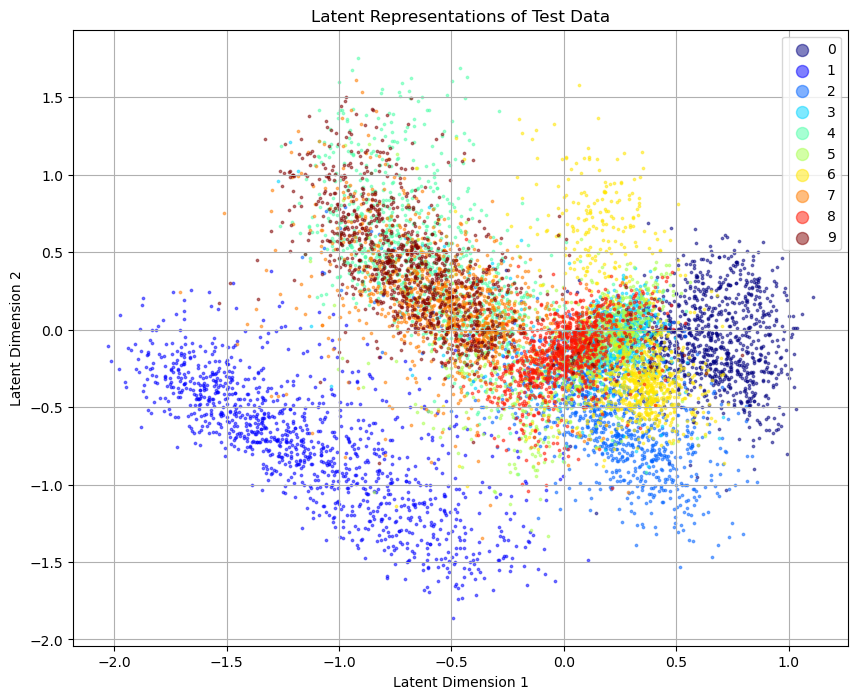

In [73]:
plot_latent_space(vae.encoder, mnist_test_ds, n_classes=10, device=device)

É interessante observar na distribuição dos dados no em comparação com com o observado no resultado do Autoencoder tradicional é que o Autoencoder Variacional distribui os dados no espaço latente tentando seguir uma distribuição normal padrão.

# Exercícios

## Exercício 1

Crie uma função para visualizar como o autoencoder reconstrói as imagens do dataset MNIST. Crie uma grade no espaço latente e gere imagens para cada ponto da grade. Para isso, você pode usar a função `np.linspace` para criar os valores de x e y no espaço latente. Em seguida, use o método `decoder` do autoencoder para gerar as imagens correspondentes.

In [27]:
def plot_latent_images(decoder, n=10, sigma=1, device='cpu', figsize=(6, 6)):
    fig, axes = plt.subplots(n, n, figsize=figsize)
    decoder.to(device)
    
    grid_x = np.linspace(-sigma, sigma, n)
    grid_y = np.linspace(-sigma, sigma, n)

    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = torch.tensor([[xi, yi]]).to(torch.float32).to(device)
                x_decoded = decoder(z_sample)
                digit = x_decoded[0].cpu().numpy().transpose(1, 2, 0).squeeze()
                axes[i, j].imshow(digit, cmap='gray')
                axes[i, j].axis('off');

    plt.tight_layout()

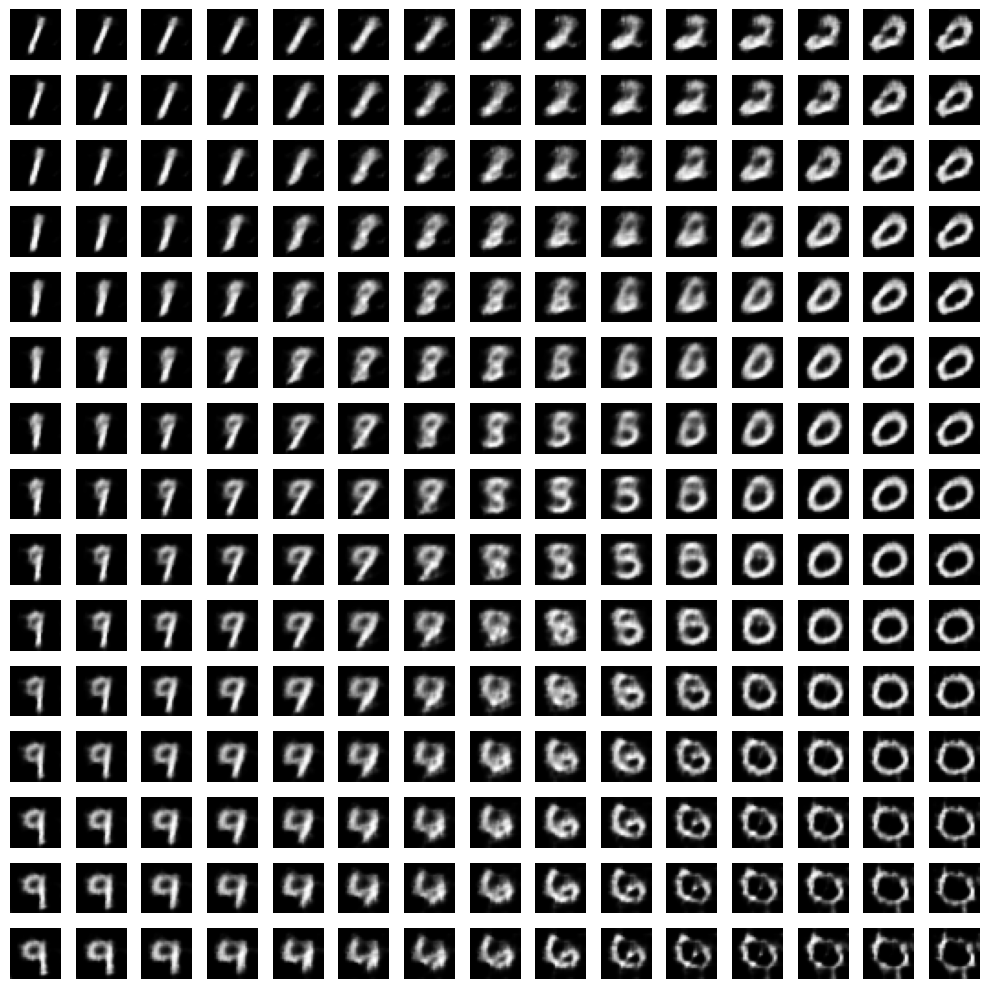

In [34]:
plot_latent_images(vae.decoder, n=15, sigma=1, device=device, figsize=(10, 10))

## Exercício 2

Teste o autoencoder variacional com mais dimensionalidades no espaço latente. Tente com 5, 20 e 50 dimensões. Compare os resultados obtidos.

<details>
<summary>Dica:</summary>

Para visualizar a representação dos dados no espaço latente, utilize um [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) para reduzir a dimensionalidade dos dados para 2 dimensões.

</details>

In [35]:
vae2 = VariationalAutoencoder(latent_size=2, n_channels=1)
vae5 = VariationalAutoencoder(latent_size=5, n_channels=1)
vae20 = VariationalAutoencoder(latent_size=20, n_channels=1)
vae50 = VariationalAutoencoder(latent_size=50, n_channels=1)

In [36]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [37]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae2.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae2, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 59.6803 train_rec_loss: 59.0316 train_kl_loss: 0.6487 | val_loss: 46.1613 val_rec_loss: 45.5512 val_kl_loss: 0.6101


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 44.3781 train_rec_loss: 43.8027 train_kl_loss: 0.5753 | val_loss: 43.2284 val_rec_loss: 42.6481 val_kl_loss: 0.5803


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 42.5815 train_rec_loss: 42.0021 train_kl_loss: 0.5794 | val_loss: 41.9951 val_rec_loss: 41.4213 val_kl_loss: 0.5738


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 41.5328 train_rec_loss: 40.9421 train_kl_loss: 0.5908 | val_loss: 41.1119 val_rec_loss: 40.5112 val_kl_loss: 0.6008


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 40.8281 train_rec_loss: 40.2245 train_kl_loss: 0.6036 | val_loss: 40.6608 val_rec_loss: 40.0416 val_kl_loss: 0.6192


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 40.3574 train_rec_loss: 39.7455 train_kl_loss: 0.6119 | val_loss: 40.1614 val_rec_loss: 39.5341 val_kl_loss: 0.6273


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 39.9727 train_rec_loss: 39.3589 train_kl_loss: 0.6138 | val_loss: 39.8299 val_rec_loss: 39.2326 val_kl_loss: 0.5973


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 39.6735 train_rec_loss: 39.0480 train_kl_loss: 0.6255 | val_loss: 39.4447 val_rec_loss: 38.8074 val_kl_loss: 0.6373


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 39.3839 train_rec_loss: 38.7530 train_kl_loss: 0.6310 | val_loss: 39.2242 val_rec_loss: 38.5736 val_kl_loss: 0.6506


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 39.1939 train_rec_loss: 38.5552 train_kl_loss: 0.6388 | val_loss: 39.2447 val_rec_loss: 38.5887 val_kl_loss: 0.6560


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 38.9858 train_rec_loss: 38.3440 train_kl_loss: 0.6417 | val_loss: 38.9770 val_rec_loss: 38.2806 val_kl_loss: 0.6964


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 38.8208 train_rec_loss: 38.1726 train_kl_loss: 0.6482 | val_loss: 38.7917 val_rec_loss: 38.2042 val_kl_loss: 0.5875


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 38.6730 train_rec_loss: 38.0258 train_kl_loss: 0.6472 | val_loss: 38.6581 val_rec_loss: 37.9991 val_kl_loss: 0.6591


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 38.5807 train_rec_loss: 37.9262 train_kl_loss: 0.6545 | val_loss: 38.5735 val_rec_loss: 37.9677 val_kl_loss: 0.6058


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 38.4622 train_rec_loss: 37.8049 train_kl_loss: 0.6573 | val_loss: 38.3142 val_rec_loss: 37.6791 val_kl_loss: 0.6352


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 38.3519 train_rec_loss: 37.6963 train_kl_loss: 0.6555 | val_loss: 38.2417 val_rec_loss: 37.5826 val_kl_loss: 0.6590


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 38.2688 train_rec_loss: 37.6128 train_kl_loss: 0.6560 | val_loss: 38.2412 val_rec_loss: 37.5845 val_kl_loss: 0.6567


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 38.1836 train_rec_loss: 37.5231 train_kl_loss: 0.6606 | val_loss: 38.3255 val_rec_loss: 37.6477 val_kl_loss: 0.6778


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 38.1485 train_rec_loss: 37.4886 train_kl_loss: 0.6598 | val_loss: 38.0335 val_rec_loss: 37.3553 val_kl_loss: 0.6782


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 38.0674 train_rec_loss: 37.4009 train_kl_loss: 0.6665 | val_loss: 38.0236 val_rec_loss: 37.3770 val_kl_loss: 0.6466


In [38]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae5.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae5, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 53.4468 train_rec_loss: 52.5876 train_kl_loss: 0.8592 | val_loss: 36.0120 val_rec_loss: 34.9240 val_kl_loss: 1.0880


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 34.1915 train_rec_loss: 33.1221 train_kl_loss: 1.0694 | val_loss: 32.4728 val_rec_loss: 31.3910 val_kl_loss: 1.0818


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 31.9371 train_rec_loss: 30.8747 train_kl_loss: 1.0624 | val_loss: 31.2436 val_rec_loss: 30.1697 val_kl_loss: 1.0739


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 30.9747 train_rec_loss: 29.9240 train_kl_loss: 1.0507 | val_loss: 30.4526 val_rec_loss: 29.4118 val_kl_loss: 1.0408


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 30.4079 train_rec_loss: 29.3719 train_kl_loss: 1.0360 | val_loss: 29.9152 val_rec_loss: 28.8583 val_kl_loss: 1.0569


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 29.9931 train_rec_loss: 28.9683 train_kl_loss: 1.0248 | val_loss: 29.6394 val_rec_loss: 28.5856 val_kl_loss: 1.0538


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 29.6634 train_rec_loss: 28.6428 train_kl_loss: 1.0206 | val_loss: 29.2824 val_rec_loss: 28.2701 val_kl_loss: 1.0122


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 29.3722 train_rec_loss: 28.3531 train_kl_loss: 1.0192 | val_loss: 29.0277 val_rec_loss: 28.0180 val_kl_loss: 1.0097


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 29.1333 train_rec_loss: 28.1063 train_kl_loss: 1.0270 | val_loss: 28.8198 val_rec_loss: 27.7771 val_kl_loss: 1.0427


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 28.9079 train_rec_loss: 27.8827 train_kl_loss: 1.0252 | val_loss: 28.6158 val_rec_loss: 27.6016 val_kl_loss: 1.0142


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 28.7002 train_rec_loss: 27.6762 train_kl_loss: 1.0240 | val_loss: 28.5014 val_rec_loss: 27.4190 val_kl_loss: 1.0824


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 28.5428 train_rec_loss: 27.5132 train_kl_loss: 1.0296 | val_loss: 28.2273 val_rec_loss: 27.1763 val_kl_loss: 1.0510


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 28.4205 train_rec_loss: 27.3899 train_kl_loss: 1.0306 | val_loss: 28.0851 val_rec_loss: 27.0598 val_kl_loss: 1.0252


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 28.2797 train_rec_loss: 27.2458 train_kl_loss: 1.0339 | val_loss: 27.9702 val_rec_loss: 26.9399 val_kl_loss: 1.0303


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 28.1593 train_rec_loss: 27.1270 train_kl_loss: 1.0323 | val_loss: 27.9374 val_rec_loss: 26.9199 val_kl_loss: 1.0175


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 28.0361 train_rec_loss: 26.9972 train_kl_loss: 1.0389 | val_loss: 27.9006 val_rec_loss: 26.8440 val_kl_loss: 1.0567


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 27.9322 train_rec_loss: 26.8935 train_kl_loss: 1.0387 | val_loss: 27.7094 val_rec_loss: 26.7455 val_kl_loss: 0.9639


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 27.8529 train_rec_loss: 26.8105 train_kl_loss: 1.0425 | val_loss: 27.6129 val_rec_loss: 26.5735 val_kl_loss: 1.0394


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 27.7446 train_rec_loss: 26.6980 train_kl_loss: 1.0466 | val_loss: 27.5051 val_rec_loss: 26.4345 val_kl_loss: 1.0706


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 27.6562 train_rec_loss: 26.6063 train_kl_loss: 1.0499 | val_loss: 27.3708 val_rec_loss: 26.2985 val_kl_loss: 1.0723


In [39]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae20.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae20, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 44.3470 train_rec_loss: 42.6351 train_kl_loss: 1.7120 | val_loss: 22.4646 val_rec_loss: 20.3104 val_kl_loss: 2.1542


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 19.9979 train_rec_loss: 17.7852 train_kl_loss: 2.2127 | val_loss: 17.5444 val_rec_loss: 15.3285 val_kl_loss: 2.2159


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 16.9261 train_rec_loss: 14.7409 train_kl_loss: 2.1852 | val_loss: 15.7906 val_rec_loss: 13.6864 val_kl_loss: 2.1042


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 15.6936 train_rec_loss: 13.5549 train_kl_loss: 2.1387 | val_loss: 14.9772 val_rec_loss: 12.8793 val_kl_loss: 2.0979


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 15.0181 train_rec_loss: 12.9078 train_kl_loss: 2.1103 | val_loss: 14.4465 val_rec_loss: 12.3535 val_kl_loss: 2.0930


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 14.5745 train_rec_loss: 12.4702 train_kl_loss: 2.1042 | val_loss: 14.0755 val_rec_loss: 11.9244 val_kl_loss: 2.1511


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 14.2398 train_rec_loss: 12.1366 train_kl_loss: 2.1032 | val_loss: 13.7758 val_rec_loss: 11.7032 val_kl_loss: 2.0726


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 13.9761 train_rec_loss: 11.8688 train_kl_loss: 2.1072 | val_loss: 13.5667 val_rec_loss: 11.4494 val_kl_loss: 2.1173


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 13.7528 train_rec_loss: 11.6449 train_kl_loss: 2.1078 | val_loss: 13.3320 val_rec_loss: 11.2358 val_kl_loss: 2.0963


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 13.5555 train_rec_loss: 11.4436 train_kl_loss: 2.1119 | val_loss: 13.1544 val_rec_loss: 10.9813 val_kl_loss: 2.1731


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 13.4156 train_rec_loss: 11.2953 train_kl_loss: 2.1203 | val_loss: 13.0358 val_rec_loss: 10.8780 val_kl_loss: 2.1579


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 13.2877 train_rec_loss: 11.1626 train_kl_loss: 2.1251 | val_loss: 13.0232 val_rec_loss: 10.8982 val_kl_loss: 2.1250


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 13.1695 train_rec_loss: 11.0429 train_kl_loss: 2.1266 | val_loss: 12.8432 val_rec_loss: 10.7187 val_kl_loss: 2.1245


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 13.0521 train_rec_loss: 10.9163 train_kl_loss: 2.1359 | val_loss: 12.7962 val_rec_loss: 10.5874 val_kl_loss: 2.2088


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 12.9610 train_rec_loss: 10.8178 train_kl_loss: 2.1432 | val_loss: 12.6721 val_rec_loss: 10.5015 val_kl_loss: 2.1706


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 12.8787 train_rec_loss: 10.7342 train_kl_loss: 2.1446 | val_loss: 12.5374 val_rec_loss: 10.4328 val_kl_loss: 2.1045


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 12.8043 train_rec_loss: 10.6533 train_kl_loss: 2.1510 | val_loss: 12.4903 val_rec_loss: 10.3153 val_kl_loss: 2.1749


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 12.7285 train_rec_loss: 10.5752 train_kl_loss: 2.1533 | val_loss: 12.5367 val_rec_loss: 10.4085 val_kl_loss: 2.1281


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 12.6473 train_rec_loss: 10.4911 train_kl_loss: 2.1562 | val_loss: 12.3679 val_rec_loss: 10.2151 val_kl_loss: 2.1528


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 12.6057 train_rec_loss: 10.4446 train_kl_loss: 2.1611 | val_loss: 12.3630 val_rec_loss: 10.1530 val_kl_loss: 2.2100


In [40]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae50.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae50, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 44.6824 train_rec_loss: 42.9315 train_kl_loss: 1.7509 | val_loss: 20.2215 val_rec_loss: 17.9212 val_kl_loss: 2.3003


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 17.5798 train_rec_loss: 15.1240 train_kl_loss: 2.4558 | val_loss: 15.3536 val_rec_loss: 12.8933 val_kl_loss: 2.4603


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 14.6783 train_rec_loss: 12.1963 train_kl_loss: 2.4820 | val_loss: 13.5466 val_rec_loss: 11.0218 val_kl_loss: 2.5249


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 13.3860 train_rec_loss: 10.8987 train_kl_loss: 2.4873 | val_loss: 12.6278 val_rec_loss: 10.1067 val_kl_loss: 2.5211


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 12.5248 train_rec_loss: 10.0439 train_kl_loss: 2.4809 | val_loss: 12.0037 val_rec_loss: 9.5403 val_kl_loss: 2.4635


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 11.9066 train_rec_loss: 9.4209 train_kl_loss: 2.4857 | val_loss: 11.3969 val_rec_loss: 8.9022 val_kl_loss: 2.4947


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 11.3918 train_rec_loss: 8.8830 train_kl_loss: 2.5088 | val_loss: 10.9759 val_rec_loss: 8.4862 val_kl_loss: 2.4897


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 10.9978 train_rec_loss: 8.4798 train_kl_loss: 2.5180 | val_loss: 10.6012 val_rec_loss: 8.0992 val_kl_loss: 2.5020


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 10.6999 train_rec_loss: 8.1645 train_kl_loss: 2.5354 | val_loss: 10.3464 val_rec_loss: 7.8482 val_kl_loss: 2.4982


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 10.4790 train_rec_loss: 7.9334 train_kl_loss: 2.5456 | val_loss: 10.1138 val_rec_loss: 7.5589 val_kl_loss: 2.5550


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 10.3040 train_rec_loss: 7.7536 train_kl_loss: 2.5504 | val_loss: 9.9318 val_rec_loss: 7.3798 val_kl_loss: 2.5520


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 10.1397 train_rec_loss: 7.5792 train_kl_loss: 2.5605 | val_loss: 9.8511 val_rec_loss: 7.3435 val_kl_loss: 2.5076


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 10.0249 train_rec_loss: 7.4669 train_kl_loss: 2.5580 | val_loss: 9.7345 val_rec_loss: 7.1450 val_kl_loss: 2.5895


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 9.9230 train_rec_loss: 7.3567 train_kl_loss: 2.5662 | val_loss: 9.6796 val_rec_loss: 7.1040 val_kl_loss: 2.5756


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 9.8186 train_rec_loss: 7.2524 train_kl_loss: 2.5662 | val_loss: 9.5729 val_rec_loss: 7.0109 val_kl_loss: 2.5619


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 9.7286 train_rec_loss: 7.1652 train_kl_loss: 2.5634 | val_loss: 9.4893 val_rec_loss: 6.9747 val_kl_loss: 2.5146


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 9.6584 train_rec_loss: 7.0929 train_kl_loss: 2.5655 | val_loss: 9.5089 val_rec_loss: 7.0010 val_kl_loss: 2.5079


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 9.5801 train_rec_loss: 7.0149 train_kl_loss: 2.5652 | val_loss: 9.3378 val_rec_loss: 6.7690 val_kl_loss: 2.5687


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 9.5092 train_rec_loss: 6.9415 train_kl_loss: 2.5678 | val_loss: 9.2815 val_rec_loss: 6.7341 val_kl_loss: 2.5474


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 9.4671 train_rec_loss: 6.8972 train_kl_loss: 2.5698 | val_loss: 9.2463 val_rec_loss: 6.6851 val_kl_loss: 2.5612


In [ ]:
def plot_multiple_reconstructions(models, dataset, n=8, device='cpu', figsize=(12, 8)):
    fig, axes = plt.subplots(len(models)+1, n, figsize=figsize)
    images = torch.cat([dataset[i][0].unsqueeze(0) for i in range(n)], dim=0).to(device)

    for i, (ax, im) in enumerate(zip(range(n), images)):
        im = im.cpu().squeeze()
        axes[0][ax].imshow(im, cmap="gray")
        axes[0][ax].axis("off")
    
    axes[0][n//2].set_title("Original")

    for i, model in enumerate(models):
        model.to(device)
        model.eval()
        with torch.no_grad():
            reconstructions = model(images)

        for j, (ax, im, rec) in enumerate(zip(range(n), images, reconstructions)):
            im = im.cpu().squeeze()
            rec = rec.cpu().squeeze()

            axes[i+1][ax].imshow(rec, cmap="gray")
            axes[i+1][ax].axis("off")

        axes[i+1][n//2].set_title(f"Latent size: {model.encoder.latent_size}")

    plt.show()

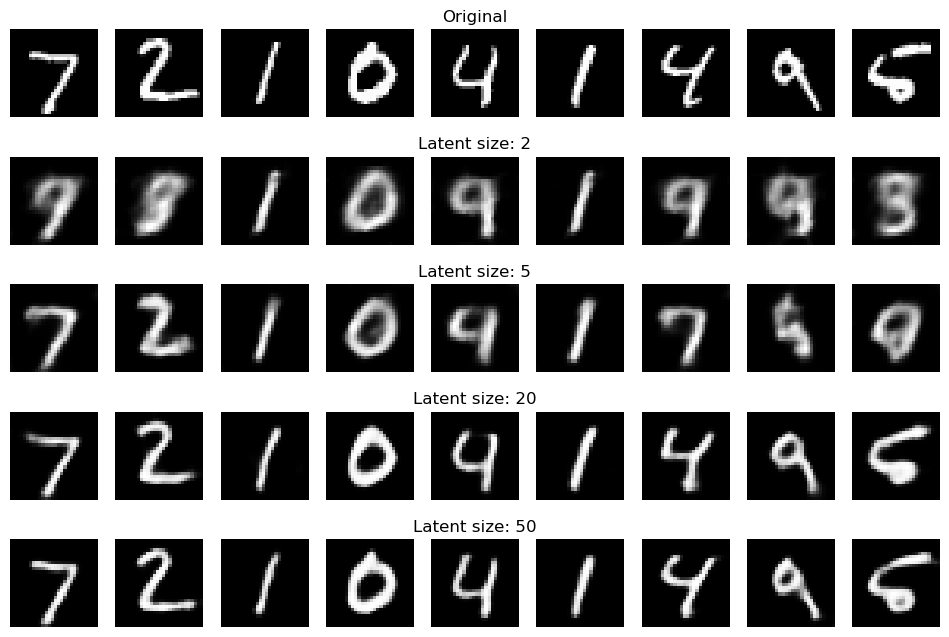

In [51]:
plot_multiple_reconstructions([vae2, vae5, vae20, vae50], mnist_test_ds, n=9, device=device)

In [ ]:
def plot_multiple_latent_spaces(
    models,
    dataset,
    n_classes=10,
    device='cpu',
    reduce_dims=None,
    figsize=(10, 10),
    label_mapper=lambda x: x,
):
    n = ceil(sqrt(len(models)))
    fig, axes = plt.subplots(n, n, figsize=figsize)

    for model, ax in zip(models, axes.ravel()):
        plot_latent_space(
            model.encoder,
            dataset,
            n_classes=n_classes,
            device=device,
            reduce_dims=reduce_dims,
            ax=ax,
            title=f"Latent size: {model.encoder.latent_size}",
            label_mapper=label_mapper,
        )

    plt.show()

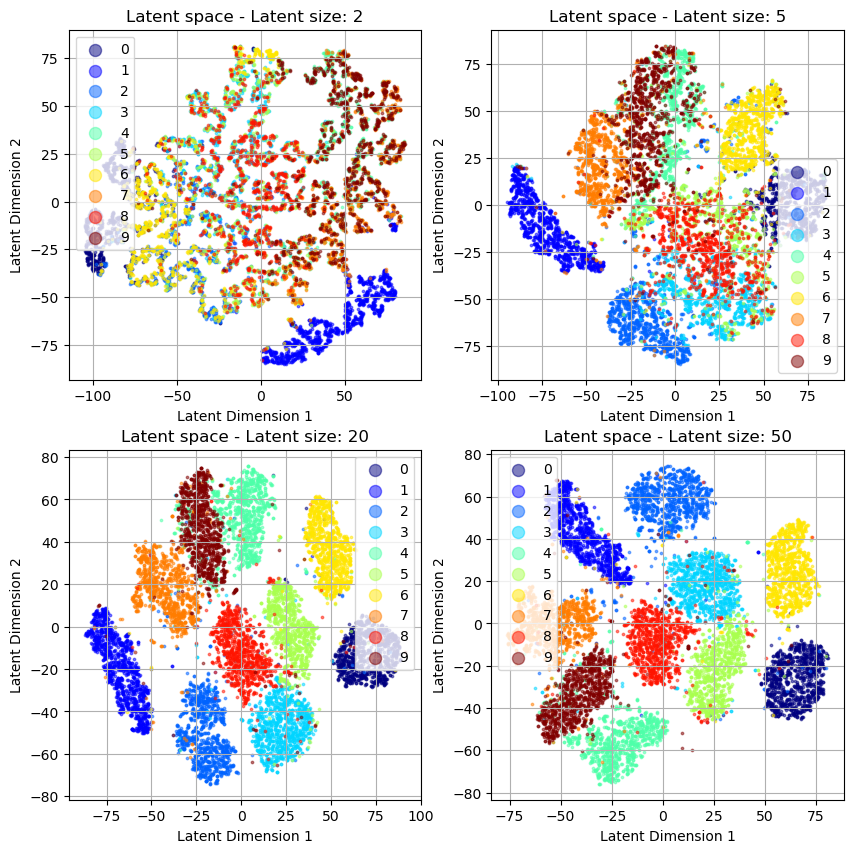

In [75]:
plot_multiple_latent_spaces([vae2, vae5, vae20, vae50], mnist_test_ds, n_classes=10, device=device, reduce_dims='tsne')

## Exercício 3

Teste o autoencoder variacional no dataset Fashion MNIST. Compare os resultados obtidos com o dataset MNIST. Teste com diferentes dimensionalidades no espaço latente e tente encontrar a menor dimensionalidade que ainda consegue reconstruir as imagens de forma satisfatória.

<details>
<summary>Dica:</summary>

O autoencoder fornecido talvez seja muito simples para o dataset Fashion MNIST. Tente aumentar a complexidade do modelo.

</details>

In [24]:
faishon_mnist_path = '/pgeoprj2/ciag2024/dados'

In [67]:
class AutoencoderFaishonMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.FashionMNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [82]:
faishon_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

faishon_mnist_labels_mapper = lambda x: faishon_mnist_labels[x]

In [85]:
faishon_mnist_train_ds = AutoencoderFaishonMNIST(
    "./data/fmnist",
    train=True,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    download=True,
    return_labels=True
)
faishon_mnist_test_ds = AutoencoderFaishonMNIST(
    "./data/fmnist",
    train=False,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
)

print(
    "Tamanho do dataset de (treino, teste):", (len(faishon_mnist_train_ds), len(faishon_mnist_test_ds))
)

Failed to download (trying next):
<urlopen error [Errno -2] Name or service not known>



RuntimeError: Error downloading train-images-idx3-ubyte.gz

In [84]:
plot_dataset(faishon_mnist_train_ds, label_mapper=faishon_mnist_labels_mapper)

In [86]:
fvae_2 = VariationalAutoencoder(latent_size=2, n_channels=1)
fvae_5 = VariationalAutoencoder(latent_size=5, n_channels=1)
fvae_20 = VariationalAutoencoder(latent_size=20, n_channels=1)
fvae_50 = VariationalAutoencoder(latent_size=50, n_channels=1)

In [87]:
faishon_mnist_train_ds.stop_return_labels()
faishon_mnist_test_ds.stop_return_labels()
faishon_train_dl = DataLoader(faishon_mnist_train_ds, batch_size=128, shuffle=True)
faishon_test_dl = DataLoader(faishon_mnist_test_ds, batch_size=128)

In [88]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_2.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_2, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 50.1090 train_rec_loss: 48.9790 train_kl_loss: 1.1300 | val_loss: 35.4740 val_rec_loss: 34.3530 val_kl_loss: 1.1210


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 34.0489 train_rec_loss: 32.9974 train_kl_loss: 1.0514 | val_loss: 33.2177 val_rec_loss: 32.2127 val_kl_loss: 1.0050


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 32.6132 train_rec_loss: 31.6284 train_kl_loss: 0.9848 | val_loss: 32.1510 val_rec_loss: 31.1840 val_kl_loss: 0.9670


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 31.7920 train_rec_loss: 30.8235 train_kl_loss: 0.9685 | val_loss: 31.4812 val_rec_loss: 30.4835 val_kl_loss: 0.9976


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 31.1726 train_rec_loss: 30.2133 train_kl_loss: 0.9593 | val_loss: 31.0839 val_rec_loss: 30.1021 val_kl_loss: 0.9818


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 30.7249 train_rec_loss: 29.7679 train_kl_loss: 0.9571 | val_loss: 30.5860 val_rec_loss: 29.6352 val_kl_loss: 0.9509


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 30.3305 train_rec_loss: 29.3812 train_kl_loss: 0.9493 | val_loss: 30.0424 val_rec_loss: 29.0879 val_kl_loss: 0.9546


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 30.0312 train_rec_loss: 29.0885 train_kl_loss: 0.9428 | val_loss: 30.0110 val_rec_loss: 29.0630 val_kl_loss: 0.9480


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 29.8010 train_rec_loss: 28.8634 train_kl_loss: 0.9376 | val_loss: 29.6060 val_rec_loss: 28.7343 val_kl_loss: 0.8718


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 29.5738 train_rec_loss: 28.6443 train_kl_loss: 0.9295 | val_loss: 29.3698 val_rec_loss: 28.4394 val_kl_loss: 0.9304


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 29.3896 train_rec_loss: 28.4683 train_kl_loss: 0.9214 | val_loss: 29.3065 val_rec_loss: 28.3864 val_kl_loss: 0.9201


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 29.2333 train_rec_loss: 28.3227 train_kl_loss: 0.9106 | val_loss: 29.0342 val_rec_loss: 28.1327 val_kl_loss: 0.9015


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 29.0870 train_rec_loss: 28.1848 train_kl_loss: 0.9022 | val_loss: 28.9279 val_rec_loss: 28.0167 val_kl_loss: 0.9112


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 28.9295 train_rec_loss: 28.0355 train_kl_loss: 0.8940 | val_loss: 28.7997 val_rec_loss: 27.8959 val_kl_loss: 0.9037


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 28.8261 train_rec_loss: 27.9325 train_kl_loss: 0.8936 | val_loss: 28.6286 val_rec_loss: 27.7328 val_kl_loss: 0.8959


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 28.7267 train_rec_loss: 27.8390 train_kl_loss: 0.8877 | val_loss: 28.5966 val_rec_loss: 27.7444 val_kl_loss: 0.8522


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 28.6093 train_rec_loss: 27.7288 train_kl_loss: 0.8805 | val_loss: 28.5567 val_rec_loss: 27.6816 val_kl_loss: 0.8751


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 28.5083 train_rec_loss: 27.6369 train_kl_loss: 0.8714 | val_loss: 28.3949 val_rec_loss: 27.5222 val_kl_loss: 0.8727


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 28.4168 train_rec_loss: 27.5478 train_kl_loss: 0.8690 | val_loss: 28.3639 val_rec_loss: 27.4821 val_kl_loss: 0.8818


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 28.3168 train_rec_loss: 27.4531 train_kl_loss: 0.8637 | val_loss: 28.0622 val_rec_loss: 27.2320 val_kl_loss: 0.8302


In [89]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_5.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_5, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 45.9286 train_rec_loss: 44.2882 train_kl_loss: 1.6404 | val_loss: 27.4373 val_rec_loss: 26.0904 val_kl_loss: 1.3470


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 25.9901 train_rec_loss: 24.6647 train_kl_loss: 1.3254 | val_loss: 24.8632 val_rec_loss: 23.5497 val_kl_loss: 1.3135


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 24.1219 train_rec_loss: 22.8418 train_kl_loss: 1.2800 | val_loss: 23.3755 val_rec_loss: 22.0498 val_kl_loss: 1.3257


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 22.9764 train_rec_loss: 21.7255 train_kl_loss: 1.2509 | val_loss: 22.5590 val_rec_loss: 21.2942 val_kl_loss: 1.2648


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 22.2522 train_rec_loss: 21.0229 train_kl_loss: 1.2294 | val_loss: 21.9526 val_rec_loss: 20.7578 val_kl_loss: 1.1948


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 21.7191 train_rec_loss: 20.5103 train_kl_loss: 1.2088 | val_loss: 21.5685 val_rec_loss: 20.3842 val_kl_loss: 1.1843


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 21.2930 train_rec_loss: 20.0990 train_kl_loss: 1.1939 | val_loss: 21.3150 val_rec_loss: 20.1769 val_kl_loss: 1.1381


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 20.9793 train_rec_loss: 19.7922 train_kl_loss: 1.1870 | val_loss: 20.9474 val_rec_loss: 19.7243 val_kl_loss: 1.2232


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 20.7425 train_rec_loss: 19.5567 train_kl_loss: 1.1859 | val_loss: 20.6988 val_rec_loss: 19.5541 val_kl_loss: 1.1447


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 20.5263 train_rec_loss: 19.3458 train_kl_loss: 1.1805 | val_loss: 20.5298 val_rec_loss: 19.3369 val_kl_loss: 1.1929


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 20.3770 train_rec_loss: 19.2009 train_kl_loss: 1.1761 | val_loss: 20.4368 val_rec_loss: 19.2700 val_kl_loss: 1.1668


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 20.2556 train_rec_loss: 19.0814 train_kl_loss: 1.1742 | val_loss: 20.2321 val_rec_loss: 19.1117 val_kl_loss: 1.1204


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 20.1117 train_rec_loss: 18.9370 train_kl_loss: 1.1747 | val_loss: 20.1683 val_rec_loss: 19.0279 val_kl_loss: 1.1403


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 20.0296 train_rec_loss: 18.8632 train_kl_loss: 1.1664 | val_loss: 20.1022 val_rec_loss: 18.9428 val_kl_loss: 1.1594


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 19.9410 train_rec_loss: 18.7760 train_kl_loss: 1.1649 | val_loss: 19.9351 val_rec_loss: 18.7478 val_kl_loss: 1.1873


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 19.8474 train_rec_loss: 18.6803 train_kl_loss: 1.1671 | val_loss: 19.8931 val_rec_loss: 18.7884 val_kl_loss: 1.1047


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 19.7786 train_rec_loss: 18.6109 train_kl_loss: 1.1677 | val_loss: 19.8688 val_rec_loss: 18.7081 val_kl_loss: 1.1607


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 19.7231 train_rec_loss: 18.5588 train_kl_loss: 1.1643 | val_loss: 19.7655 val_rec_loss: 18.5955 val_kl_loss: 1.1701


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 19.6653 train_rec_loss: 18.4981 train_kl_loss: 1.1673 | val_loss: 19.8372 val_rec_loss: 18.6868 val_kl_loss: 1.1504


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 19.6135 train_rec_loss: 18.4476 train_kl_loss: 1.1659 | val_loss: 19.7563 val_rec_loss: 18.6028 val_kl_loss: 1.1536


In [90]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_20.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_20, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 42.4268 train_rec_loss: 40.5489 train_kl_loss: 1.8779 | val_loss: 22.9721 val_rec_loss: 21.0297 val_kl_loss: 1.9424


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 21.2661 train_rec_loss: 19.3563 train_kl_loss: 1.9098 | val_loss: 20.0340 val_rec_loss: 18.1737 val_kl_loss: 1.8603


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 19.2004 train_rec_loss: 17.3419 train_kl_loss: 1.8585 | val_loss: 18.6867 val_rec_loss: 16.8250 val_kl_loss: 1.8616


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 18.0620 train_rec_loss: 16.2537 train_kl_loss: 1.8083 | val_loss: 17.6524 val_rec_loss: 15.8482 val_kl_loss: 1.8042


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 17.2923 train_rec_loss: 15.5300 train_kl_loss: 1.7623 | val_loss: 17.0484 val_rec_loss: 15.2944 val_kl_loss: 1.7540


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 16.7706 train_rec_loss: 15.0344 train_kl_loss: 1.7362 | val_loss: 16.7976 val_rec_loss: 15.0755 val_kl_loss: 1.7221


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 16.3786 train_rec_loss: 14.6618 train_kl_loss: 1.7169 | val_loss: 16.3146 val_rec_loss: 14.6243 val_kl_loss: 1.6903


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 16.0864 train_rec_loss: 14.3688 train_kl_loss: 1.7175 | val_loss: 16.0139 val_rec_loss: 14.3115 val_kl_loss: 1.7024


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 15.8501 train_rec_loss: 14.1307 train_kl_loss: 1.7194 | val_loss: 15.8531 val_rec_loss: 14.1115 val_kl_loss: 1.7417


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 15.6621 train_rec_loss: 13.9435 train_kl_loss: 1.7186 | val_loss: 15.6619 val_rec_loss: 13.9820 val_kl_loss: 1.6800


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 15.5142 train_rec_loss: 13.7917 train_kl_loss: 1.7225 | val_loss: 15.4463 val_rec_loss: 13.7062 val_kl_loss: 1.7401


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 15.3623 train_rec_loss: 13.6375 train_kl_loss: 1.7248 | val_loss: 15.3707 val_rec_loss: 13.5916 val_kl_loss: 1.7792


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 15.2334 train_rec_loss: 13.5052 train_kl_loss: 1.7282 | val_loss: 15.2570 val_rec_loss: 13.5809 val_kl_loss: 1.6761


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 15.1403 train_rec_loss: 13.4066 train_kl_loss: 1.7337 | val_loss: 15.1213 val_rec_loss: 13.3966 val_kl_loss: 1.7247


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 15.0386 train_rec_loss: 13.3049 train_kl_loss: 1.7337 | val_loss: 15.1276 val_rec_loss: 13.3772 val_kl_loss: 1.7504


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 14.9400 train_rec_loss: 13.2024 train_kl_loss: 1.7376 | val_loss: 14.9929 val_rec_loss: 13.2109 val_kl_loss: 1.7821


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 14.8760 train_rec_loss: 13.1332 train_kl_loss: 1.7429 | val_loss: 14.8737 val_rec_loss: 13.1452 val_kl_loss: 1.7285


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 14.8028 train_rec_loss: 13.0560 train_kl_loss: 1.7468 | val_loss: 14.9907 val_rec_loss: 13.2935 val_kl_loss: 1.6972


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 14.7341 train_rec_loss: 12.9860 train_kl_loss: 1.7481 | val_loss: 14.7277 val_rec_loss: 12.9755 val_kl_loss: 1.7523


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 14.6751 train_rec_loss: 12.9266 train_kl_loss: 1.7485 | val_loss: 14.6887 val_rec_loss: 12.9550 val_kl_loss: 1.7337


In [91]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_50.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_50, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 39.2729 train_rec_loss: 37.5771 train_kl_loss: 1.6957 | val_loss: 21.3150 val_rec_loss: 19.5169 val_kl_loss: 1.7981


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 18.9527 train_rec_loss: 17.1924 train_kl_loss: 1.7603 | val_loss: 17.7156 val_rec_loss: 15.9445 val_kl_loss: 1.7711


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 16.8243 train_rec_loss: 15.0433 train_kl_loss: 1.7810 | val_loss: 16.3385 val_rec_loss: 14.5244 val_kl_loss: 1.8141


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 15.7679 train_rec_loss: 13.9537 train_kl_loss: 1.8142 | val_loss: 15.4189 val_rec_loss: 13.5952 val_kl_loss: 1.8237


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 15.0456 train_rec_loss: 13.1904 train_kl_loss: 1.8552 | val_loss: 14.7362 val_rec_loss: 12.8851 val_kl_loss: 1.8511


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 14.5013 train_rec_loss: 12.6079 train_kl_loss: 1.8934 | val_loss: 14.3794 val_rec_loss: 12.4695 val_kl_loss: 1.9099


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 14.0927 train_rec_loss: 12.1683 train_kl_loss: 1.9244 | val_loss: 14.0504 val_rec_loss: 12.1504 val_kl_loss: 1.9000


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 13.7759 train_rec_loss: 11.8263 train_kl_loss: 1.9496 | val_loss: 13.6944 val_rec_loss: 11.7772 val_kl_loss: 1.9172


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 13.5119 train_rec_loss: 11.5403 train_kl_loss: 1.9716 | val_loss: 13.4884 val_rec_loss: 11.4973 val_kl_loss: 1.9911


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 13.2952 train_rec_loss: 11.3064 train_kl_loss: 1.9888 | val_loss: 13.2777 val_rec_loss: 11.3215 val_kl_loss: 1.9562


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 13.1018 train_rec_loss: 11.0917 train_kl_loss: 2.0101 | val_loss: 13.0805 val_rec_loss: 11.0680 val_kl_loss: 2.0124


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 12.9330 train_rec_loss: 10.9067 train_kl_loss: 2.0264 | val_loss: 12.9726 val_rec_loss: 10.9303 val_kl_loss: 2.0424


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 12.7982 train_rec_loss: 10.7582 train_kl_loss: 2.0401 | val_loss: 12.9656 val_rec_loss: 10.9677 val_kl_loss: 1.9979


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 12.6672 train_rec_loss: 10.6186 train_kl_loss: 2.0486 | val_loss: 12.7183 val_rec_loss: 10.6643 val_kl_loss: 2.0540


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 12.5559 train_rec_loss: 10.4941 train_kl_loss: 2.0618 | val_loss: 12.6083 val_rec_loss: 10.5282 val_kl_loss: 2.0800


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 12.4640 train_rec_loss: 10.3939 train_kl_loss: 2.0702 | val_loss: 12.5198 val_rec_loss: 10.4699 val_kl_loss: 2.0498


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 12.3772 train_rec_loss: 10.2965 train_kl_loss: 2.0807 | val_loss: 12.4095 val_rec_loss: 10.2915 val_kl_loss: 2.1179


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 12.3000 train_rec_loss: 10.2130 train_kl_loss: 2.0869 | val_loss: 12.4429 val_rec_loss: 10.3362 val_kl_loss: 2.1067


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 12.2547 train_rec_loss: 10.1593 train_kl_loss: 2.0955 | val_loss: 12.3034 val_rec_loss: 10.1849 val_kl_loss: 2.1185


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 12.1839 train_rec_loss: 10.0842 train_kl_loss: 2.0997 | val_loss: 12.2316 val_rec_loss: 10.1080 val_kl_loss: 2.1236


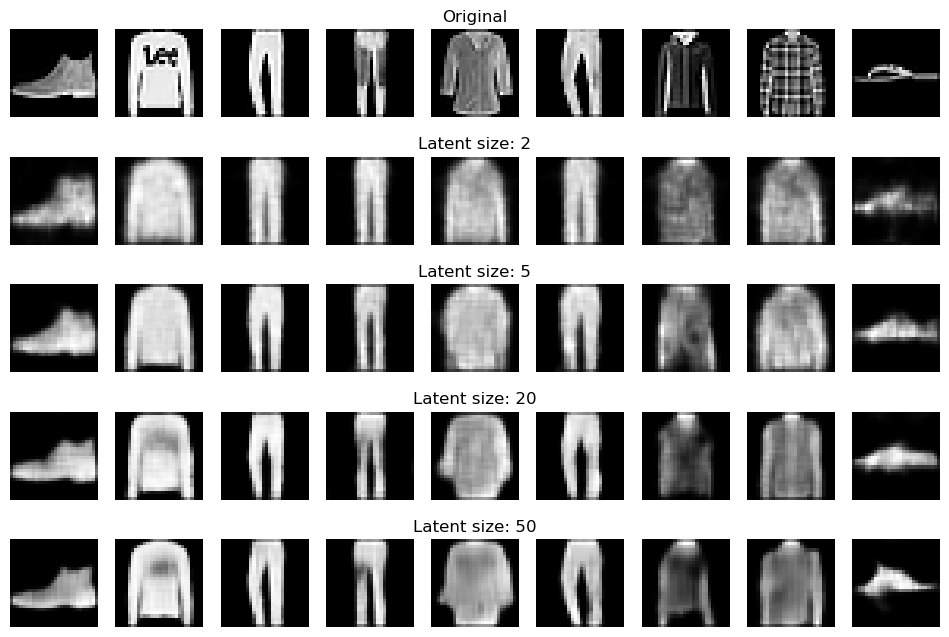

In [92]:
plot_multiple_reconstructions([fvae_2, fvae_5, fvae_20, fvae_50], faishon_mnist_test_ds, n=9, device=device)

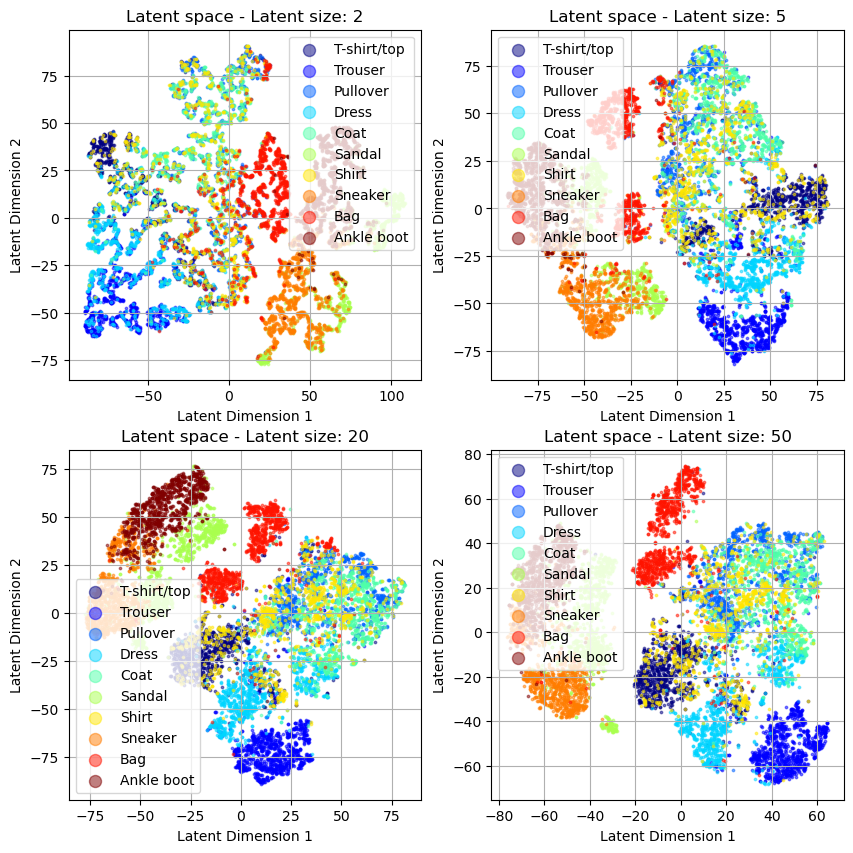

In [93]:
plot_multiple_latent_spaces(
    [fvae_2, fvae_5, fvae_20, fvae_50],
    faishon_mnist_test_ds,
    n_classes=10,
    device=device,
    reduce_dims='tsne',
    label_mapper=faishon_mnist_labels_mapper,
)